In [1]:
import plotly.graph_objects as go
# import kaleido
from plotly.subplots import make_subplots
import plotly.io as pio
import pandas as pd
import numpy as np
import json

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# local modules 
import sys
sys.path.insert(0, "../scripts")
import helpers as h
import seaborn as sns

In [2]:
a00, a01 = h.import_desired_data("A", "15T")
# TODO edit in function 
a00.set_index(a00["DateTime"].values, inplace=True)
a01.set_index(a01["DateTime"].values, inplace=True)
print(a00["Window Open"].unique(), a01["Window Open"].unique(), a00.columns)

[1.] [0. 1.] Index(['DateTime', 'Temp C', 'RH %', 'Room', 'Ambient Temp', 'Ambient RH',
       'Window Open'],
      dtype='object')


## observation 

In [3]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
print(period)

stl_obs = seasonal_decompose(a01["Temp C"],model='additive', period=period)

# difference between stl and its deriv 
stl_obs_minus_obs = h.normalize(h.normalize(stl_obs.seasonal) - h.normalize(a01["Temp C"]))



# calculate derivative of observation 
obs_deriv = h.normalize(pd.Series(np.gradient(a01["Temp C"]), a01.index, name='obs_deriv'))

stl_deriv = seasonal_decompose(obs_deriv,model='additive', period=period)

# stl_obs.plot();
# stl_deriv.plot();

96


In [4]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Temp C"]), 
                    mode='lines',
                    name="Obs"
                ))




fig.add_trace(go.Scatter(
                    x=stl_obs.seasonal.index,
                    y=h.normalize(stl_obs.seasonal), 
                    mode='lines',
                    name="Obs STL "
                ))


fig.add_trace(go.Scatter(
                    x=stl_obs_minus_obs.index,
                    y=stl_obs_minus_obs, 
                    mode='lines',
                    name="stl_obs_minus_obs "
                ))

                

fig.add_trace(go.Scatter(
                    x=obs_deriv.index,
                    y=obs_deriv, 
                    mode='lines',
                    name="Obs 1st Deriv "
                ))

fig.add_trace(go.Scatter(
                    x=stl_deriv.seasonal.index,
                    y=h.normalize(stl_deriv.seasonal), 
                    mode='lines',
                    name="Deriv STL"
                ))

fig.update_xaxes(
    dtick=4*60*60*1000, #1 hr in miliseconds,
    tickformat='%a-%H')

## ambient data 

96


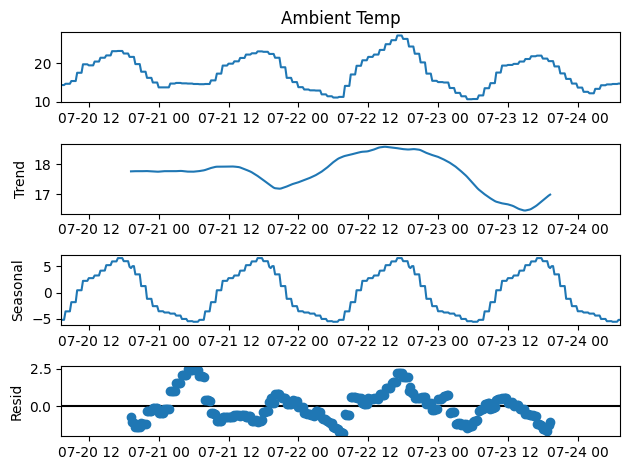

In [5]:
# period => # samples per unit in length of time over which seasonality occurs (here, 4 samples/1 hour) * length of time over which seasonality occurs (here, 24 hours)
n_samples = 4
seasonality_period = 24
period = n_samples*seasonality_period
print(period)

results_amb = seasonal_decompose(a01["Ambient Temp"],model='additive', period=period)

results_amb.plot();

In [6]:
# smooth ambient data in order to compare ...
smooth_ambient = a01["Ambient Temp"].ewm(com=4).mean()

# decomposition of the ambient data
stl_amb = seasonal_decompose(smooth_ambient,model='additive', period=period)

stl_amb_norm = h.normalize(stl_amb.seasonal)

# ambient stl - observation 
stl_amb_minus_obs = h.normalize(stl_amb_norm - h.normalize(a01["Temp C"])) #stamo 

# calculate derivative of observation 
stl_amb_minus_obs_deriv = h.normalize(pd.Series(np.gradient(stl_amb.seasonal), stl_amb.seasonal.index, name='stamo_deriv'))

# stl_amb.plot();

In [7]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Window Open"]), 
                    mode='lines',
                    name="Window Sched",
                    line=dict(width=1),
                ))

fig.add_trace(go.Scatter(
                    x=a01["DateTime"].index,
                    y=h.normalize(a01["Temp C"]), 
                    mode='lines',
                    name="Obs"
                ))




fig.add_trace(go.Scatter(
                    x=stl_obs.seasonal.index,
                    y=h.normalize(stl_obs.seasonal), 
                    mode='lines',
                    name="Obs STL "
                ))


fig.add_trace(go.Scatter(
                    x=stl_amb_norm.index,
                    y=stl_amb_norm, 
                    mode='lines',
                    name="Ambient STL "
                ))

                

fig.add_trace(go.Scatter(
                    x=stl_amb_minus_obs.index,
                    y=stl_amb_minus_obs, 
                    mode='lines',
                    name="Amb STL - Obs "
                ))

# fig.add_trace(go.Scatter(
#                     x=stl_deriv.seasonal.index,
#                     y=h.normalize(stl_deriv.seasonal), 
#                     mode='lines',
#                     name="Deriv STL"
#                 ))

fig.update_xaxes(
    dtick=4*60*60*1000, #1 hr in miliseconds,
    tickformat='%a-%H')

## autocorelation

In [8]:

acorr = sm.tsa.acf(a01["Temp C"], nlags = len(a01["Temp C"])-1)

acorr2 = sm.tsa.acf(obs_deriv, nlags = len(obs_deriv)-1)


In [14]:
acorr = sm.tsa.acf(a01["Temp C"])
print(acorr)
len(acorr), len(a01["Temp C"])

[1.         0.97783677 0.94882573 0.91427946 0.87674998 0.83624387
 0.79374523 0.75020994 0.70678784 0.66392262 0.62161937 0.58012957
 0.53961683 0.50012802 0.4615806  0.42386422 0.38641297 0.34873196
 0.3110339  0.27317085 0.23576238 0.19917465 0.16278447 0.12672948
 0.09138642 0.05689794]


(26, 385)

(26, 385)

In [15]:
acorr = sm.tsa.acf(a01["Temp C"], nlags = len(a01["Temp C"])-1)
print(acorr)
len(acorr), len(a01["Temp C"])

[ 1.00000000e+00  9.77836773e-01  9.48825732e-01  9.14279463e-01
  8.76749983e-01  8.36243868e-01  7.93745226e-01  7.50209943e-01
  7.06787837e-01  6.63922625e-01  6.21619372e-01  5.80129566e-01
  5.39616829e-01  5.00128021e-01  4.61580597e-01  4.23864216e-01
  3.86412968e-01  3.48731956e-01  3.11033902e-01  2.73170850e-01
  2.35762381e-01  1.99174645e-01  1.62784471e-01  1.26729484e-01
  9.13864157e-02  5.68979412e-02  2.35308360e-02 -8.04078250e-03
 -3.88486441e-02 -6.89692771e-02 -9.81804151e-02 -1.27150640e-01
 -1.56379569e-01 -1.85354550e-01 -2.14183597e-01 -2.42957728e-01
 -2.71695756e-01 -2.99802606e-01 -3.27120974e-01 -3.52949959e-01
 -3.76541494e-01 -3.98145787e-01 -4.17714143e-01 -4.33927703e-01
 -4.46460684e-01 -4.54834116e-01 -4.58387952e-01 -4.57470949e-01
 -4.52961717e-01 -4.45213689e-01 -4.34699300e-01 -4.21742257e-01
 -4.06498145e-01 -3.89202569e-01 -3.70576924e-01 -3.51342951e-01
 -3.32110706e-01 -3.12804334e-01 -2.93437894e-01 -2.74006049e-01
 -2.54994309e-01 -2.36918

(385, 385)

In [10]:
fig = go.Figure()


fig.add_trace(go.Scatter(
                    x=list(range(len(acorr))),
                    y=acorr, 
                    mode='markers',
                    name="Acorr"
                ))

fig.add_trace(go.Scatter(
                    x=list(range(len(acorr2))),
                    y=acorr2, 
                    mode='markers',
                    name="Acorr2"
                ))

